**MATE40001 Computing Challenge**

Calysta Tesiman

Shawn Huang

Amelia Spindler

Romain Santeiu

Omari Newton

In [1]:
"""
Person Class
"""

#The Person class is the basic building block of the simulation
#It creates a person with the attributes needed to run the simulation
#This includes their age, vaccination status, whether they're sick or not, etc.
#These "people" inhabit the grid spaces that make up the country, which come in the next cell

import random as rnd
import math
import numpy as np

#Gaussian function for mobility factor
def g(x, mobVar, mobMean):
    return (1/np.sqrt(2*math.pi))*math.exp(-((x-mobMean)**2)/(2*mobVar))

#Defining the person class
class Person():
    #Initialisation of the people
    def __init__(self, nQ):
        #Living Status
        self.alive = True
        #Vaccination Status
        self.vacStatus = False
        #Infection Status
        self.infStatus = False
        #Quarantine Status
        self.quaStatus = False
        #Figuring out age, 20% below 20 y.o, 60% 21 - 60 y.o, 20% 61 - 100 y.o
        ageDice = rnd.random()
        if ageDice <= 0.2:
            self.age = rnd.randint(0, 20)
        if ageDice > 0.2 and ageDice <= 0.8:
            self.age = rnd.randint(21, 60)
        if ageDice > 0.8:
            self.age = rnd.randint(61, 100)
        #Mobility factor
        self.mobFact = g(self.age, 10, 30)
        #Days Sick
        self.daysSick = 0
        #Days Quarantined
        self.daysQua = 0

        #Quarantine Duration
        self.quarantineDuration = nQ

    def updateStatus(self):
        #Tracks how many days since infection
        if self.alive:
            if self.infStatus:
                self.daysSick += 1
            #Resets counter if they're not infected anymore
            elif self.infStatus == False:
                self.daysSick = 0
            #Sets quarantine status as true when days sick reaches 3
            if self.daysSick >= 3:
                self.quaStatus = True
            #If quarantine status is true, adds to the days quarantined counter, also reduces mobility factor to 0
            if self.quaStatus == True:
                self.daysQua += 1
                self.mobFact = 0
            #If days quarantined reaches the quarantine duration nQ, resets 
            if self.daysQua >= self.quarantineDuration:
                self.quaStatus = False
                self.daysQua = 0
                self.mobFact = g(self.age, 10, 30)
        return

#Functions for returning person attributes

    def isAlive(self): #Function for if they're alive
        return self.alive

    def isQuarantined(self): #Function for returning quarantine status
        return self.quaStatus

    def isInfected(self): #Function for returning infected status
        return self.infStatus
    
    def isVaccinated(self): #Function for returning vaccination status
        return self.vacStatus

    def daysSinceInfection(self): #Function for returning days sick
        return self.daysSick

#Functions for modifying person attributes

    def getsInfected(self): #Function for getting infected
        self.infStatus = True

    def getsCured(self): #Function for getting cured
        self.infStatus = False

    def getsVaccinated(self): #Function for getting vaccinated
        self.vacStatus = True

    def getsQuarantined(self): #Function for getting quarantined
        self.quaStatus = True

    def die(self): #Function for literally dying
        self.alive = False
        #Resets all the other stuff so dead don't contribute to stats
        self.infStatus = False
        self.quaStatus = False
        self.vacStatus = False


In [2]:
"""
Country Class
"""

#The Country class is the next step up on the class hierarchy, above the Person class
#Each country is a four by four grid of 16 "regions", which get inhabited by people
#People in a region can move around to neighbouring regions within their country
#Alternatively, if they are in the airport region, they can fly to other countries and move around there

class Country():

    def __init__(self, name, population, regionShape, vaccinatedFraction, activePolicies, world):
        
        self.name = name

        #Create the regions of the country
        self.regions = np.empty(regionShape, dtype=object)
        for coordinate, _ in np.ndenumerate(self.regions): self.regions[coordinate] = list()
        self.regionShape = regionShape

        #Create the region stats
        self.regionStats = np.full(regionShape, {"alive": 0, "dead": 0, "infected": 0, "quarantined": 0}, dtype=object)

        #Set the world that this country is in
        self.world = world

        #Set the active policies
        #(Dict with 4 values, either true or false: {"vaccination", "testing", "banFlights", "lockdown"})
        self.activePolicies = activePolicies

        if self.activePolicies["vaccination"]:
            vaccinatedFraction = 1
            
        #For each number in population  
        for i in range(population):

            #Create a new person object
            person = Person(world.LOQuarantine)

            #Vaccinate a certain fraction of the population
            if i < (population * vaccinatedFraction):
                person.getsVaccinated()

            #Infect a cetain fraction of the population
            if i < 10:
                person.getsInfected()
            
            #Assign the person to a random region
            self.regions[rnd.randint(0, regionShape[0] - 1), rnd.randint(0, regionShape[1] - 1)].append(person)

        #Set up counters
        #print([person.age for person in self.regions[0, 0]])
        self.countryAlive, self.countryDead, self.countryQuarantined, self.countryInfected = 0, 0, 0, 0

    #Function for counting all the different stats for each day
    def dayCount(self, dayNumber):
        
        #Reset counters for the country
        self.countryAlive, self.countryDead, self.countryQuarantined, self.countryInfected = 0, 0, 0, 0

        #Loop through each region in the country        
        for coordinate, people in np.ndenumerate(self.regions):

            self.regionStats[coordinate] = {"alive": 0, "dead": 0, "infected": 0, "quarantined": 0}

            #Loop through each person in the list in each region
            for i in range(len(people)):
                person = people[i]

                #Region Count alive, infected, quarantined, dead
                if person.isAlive():
                    self.regionStats[coordinate]["alive"] += 1
                else:
                    self.regionStats[coordinate]["dead"] += 1

                if person.isQuarantined():
                    self.regionStats[coordinate]["quarantined"] += 1
                    
                if person.isInfected():
                    self.regionStats[coordinate]["infected"] += 1 

            #Add the region totals to the country        
            self.countryAlive += self.regionStats[coordinate]["alive"]
            self.countryDead += self.regionStats[coordinate]["dead"]
            self.countryQuarantined += self.regionStats[coordinate]["quarantined"]
            self.countryInfected += self.regionStats[coordinate]["infected"]

        #If this is a multiple of 10 day, save data to file
        if dayNumber % 10 == 0:
            self.saveToFile(dayNumber)

        return self.countryAlive, self.countryDead, self.countryInfected, self.countryQuarantined

    def saveToFile(self, dayNumber):
        with open("{:s}_{:05d}.txt".format(self.name, dayNumber), "w") as f:
            f.write("{:d}, {:d}, {:d}, {:d}".format(self.countryAlive, self.countryDead, self.countryInfected, self.countryQuarantined))

# Within this cell also contains the dayAction function, which determines what a person can do each day
# They can go through 4 actions each day with an equal probability:
# 1. They can move around to different regions as aforementioned
# 2. They can roll a dice of if they will die or not (probability of which is determined in the Person class)
# 3. They can roll a dice of whether they will recover from COVID if they are sick or if they will be infected by COVID if they are healthy
# 4. They can do nothing

    def dayAction(self, dayNumber):
        #Loop through each region in the list
        for coordinate, people in np.ndenumerate(self.regions):

            #We create a copy of the list to avoid the problem of removing items from a list we are iterating through
            for person in list(people):

                #Action tree for each alive person
                if person.isAlive():
                    actionDice = rnd.random()
                    if actionDice <= 0.25:
                        self.movement(person, coordinate)
                    if actionDice > 0.25 and actionDice <= 0.50:
                        self.dying(person)
                    if actionDice > 0.50 and actionDice <= 0.75:
                        if person.isInfected():
                            self.recovering(person)
                        else:
                            self.gettingInfected(person, self.regionStats[coordinate]["infected"] 
                                                 - self.regionStats[coordinate]["quarantined"], self.regionStats[coordinate]["alive"])
                    #The last 25% represents the person doing nothing

                    #Testing if the policy has been activated
                    if self.activePolicies["testing"]:
                        self.test(person)

                    #Update the person
                    person.updateStatus()


    #Function for testing people, and if person is infected, the person enters quarantine
    def test(self, person):
        testDice = rnd.random()
        if testDice < 0.5:
            if person.isInfected():
                person.getsQuarantined()

    #Function to determine the movement of a person 
    def movement(self, person, currentCoordinates):
        mobDice = rnd.random() 

        #If the person is able to move 
        if person.mobFact > mobDice and not self.activePolicies["lockdown"]:

            #Randomly try an action (either move left, right, down, up, or fly)
            #Check if the action is valid, and if it is do it, if not randomly try another action
            while True:
                actionDice = rnd.random()
                if actionDice < 0.20: 
                    newCoordinates = (currentCoordinates[0] + 1, currentCoordinates[1])
                if actionDice >= 0.20 and actionDice < 0.40:
                    newCoordinates = (currentCoordinates[0] - 1, currentCoordinates[1])
                if actionDice >= 0.40 and actionDice < 0.60:
                    newCoordinates = (currentCoordinates[0], currentCoordinates[1] + 1)
                if actionDice >= 0.60 and actionDice < 0.80:
                    newCoordinates = (currentCoordinates[0], currentCoordinates[1] - 1)
                if actionDice >= 0.80:
                    if currentCoordinates == (0, 0) and not self.activePolicies["banFlights"]:

                        #Get the current region list
                        regionList = self.regions[currentCoordinates]

                        #Fly out of country (remove person from region)
                        regionList.pop(regionList.index(person))

                        #Fly to another country (calling the world class)
                        self.world.flight(self, person)
                        
                        break
            
                #Checks if the new coordinates are valid, if they are, sets them as the current coordinates
                elif (newCoordinates[0] >= 0 and newCoordinates[0] < self.regionShape[0]) and (newCoordinates[1] >= 0 and newCoordinates[1] < self.regionShape[1]):
                    
                    #Get the current region list
                    regionList = self.regions[currentCoordinates]

                    #Fly out of country (remove person from region)
                    regionList.pop(regionList.index(person))

                    #Add person to the new region that they moved to
                    self.regions[newCoordinates].append(person)

                    break
                                
    #Called if a person flies into a region
    def flyIntoRegion(self, person):
        self.regions[0, 0].append(person)

    #Will kill someone if they roll a probability less than probability of dying (pD)
    def dying(self, person):
        dieDice = rnd.random()
        if person.isInfected():
            pD = min(1, (1 - math.exp(-person.age/18250)) * self.world.mortality)
        else:
            pD = min(1, (1 - math.exp(-person.age/18250)) * 1)
        if dieDice < pD:
            person.die()
        
    #Will recover someone from COVID if they roll a probability less than probability of recovering (pR)
    def recovering(self, person):
        recoverDice = rnd.random()
        pR = 1 - math.exp(-person.daysSinceInfection()/2)
        if recoverDice < pR:
            person.getsCured()

    ##Will infect someone if they roll a probability less than probability of infection (pI)
    def gettingInfected(self, person, regionActive, regionAlive):

        if regionAlive != 0: #Prevent divide by 0 error
            infDice = rnd.random()
            if person.isVaccinated():
                pI = min(1, (self.world.parameter * regionActive/regionAlive)*(1-self.world.vaccineEfficacy))
            else:
                pI = min(1, self.world.parameter * regionActive/regionAlive)
            if infDice < pI:
                person.getsInfected()

In [3]:
""" 
World Class
"""

# This is the World Class where we keep track of the total numbers from all of the countries per simulation which is translated in the graph. The class "World" keeps 
# information about the parameters and the total number of people alive, dead, infected and quarantined. 

# This class also contains the flight function, where we can determine where a person could travel from their own country 
from matplotlib import pyplot as plt

#Defining the world class 
class World():
    def __init__(self, vE, xM, nQ, R): 
        self.vaccineEfficacy = vE
        self.mortality = xM
        self.LOQuarantine = nQ
        self.parameter = R 
        self.deadArray = np.empty(0)
        self.aliveArray = np.empty(0)
        self.infectedArray = np.empty(0)
        self.quarantinedArray= np.empty(0)
        self.worldDead = 0
        self.worldAlive = 0 
        self.worldQuarantined = 0
        self.worldInfected = 0 
        

    #define the country list attribute of world 
    def setCountryList(self, countryList):
        self.countryList = countryList
        
    #function for people flying to another country
    def flight(self, country, person):

        #Loop until we find a country that isnt the origin country, then send the person to that country
        while True:
            RNpick = rnd.choice(range(len(self.countryList)))
            countryPick = self.countryList[RNpick]

            if country != countryPick:
                countryPick.flyIntoRegion(person)
                break
    
    #Function that counts the total number of people (in the world) alive, dead, infected, and quarantined in a day     
    def day(self, dayNumber):
        #Reset the daily counters
        self.worldAlive, self.worldDead, self.worldInfected, self.worldQuarantined = 0, 0, 0, 0

        #Count up all the stats first
        for country in self.countryList:
            countryAlive, countryDead, countryInfected, countryQuarantined = country.dayCount(dayNumber)

            self.worldDead += countryDead
            self.worldAlive += countryAlive
            self.worldInfected += countryInfected
            self.worldQuarantined += countryQuarantined
        
        #Add the values to the array for graphing
        self.deadArray = np.append(self.deadArray, self.worldDead)
        self.aliveArray = np.append(self.aliveArray, self.worldAlive)
        self.infectedArray = np.append(self.infectedArray, self.worldInfected)
        self.quarantinedArray = np.append(self.quarantinedArray, self.worldQuarantined)

        # print("Day: {:5d}, Alive: {:5d}, Dead: {:5d}, Infected: {:5d}, Quarantined: {:5d}".format(dayNumber, self.worldAlive, self.worldDead, self.worldInfected, self.worldQuarantined))

        #Run the actions for each person each day
        for country in self.countryList:
            country.dayAction(dayNumber)

In [4]:
"""
Simulation Class
"""
#List of possible country names to pick from
countryNames = ["Antilea", "Shawntopia", "Romainistan", "Graviland", "Glabber"]

class Simulation():

    def __init__(self, nWorlds, daysPerSimulation, worldParameters, nCountries, countryShape, population, vaccinatedFraction, activePolicies):

        #self.worlds keeps a list of all the worlds in the simulation
        self.worlds = [None] * nWorlds
        self.daysPerSimulation = daysPerSimulation

        #Create the number of worlds required by the simulation        
        for i in range(nWorlds):
            world = World(*worldParameters)
            countryList = [Country(rnd.choice(countryNames), population, countryShape, vaccinatedFraction, activePolicies, world) for i in range(nCountries)]
            world.setCountryList(countryList)
            self.worlds[i] = world

    """
    Run the actual simulation

    For each day, go through each world and call its day function
    """
    def run(self):

        #For each day in the number of simulations
        for dayNumber in range(self.daysPerSimulation):
            #For each world in the simulation, run it for the day
            for world in self.worlds:
                world.day(dayNumber)

    def plot(self):
        #For each world plot the data
        self.averageAlive         = np.average([world.aliveArray for world in self.worlds], axis=0)
        self.averageDead          = np.average([world.deadArray for world in self.worlds], axis=0)
        self.averageInfected      = np.average([world.infectedArray for world in self.worlds], axis=0)
        self.averageQuarantined   = np.average([world.quarantinedArray for world in self.worlds], axis=0)

        self.plotDvA(self.averageDead, self.averageAlive)
        self.plotIvH(self.averageInfected, self.averageQuarantined)

        return self.averageAlive, self.averageDead, self.averageInfected, self.averageQuarantined
        
    #This function plots the total number of Alive or Dead people in the whole world with x axis as day 
    def plotDvA(self, dead, alive):
        plt.xlabel("Day")
        plt.ylabel("Number of people")
        x = np.array(range(self.daysPerSimulation))
        plt.plot(x, dead, 'r-', label = "dead")
        plt.plot(x, alive,'g-', label = "alive")
        plt.legend()
        plt.show()

    #This function plots the total number of people infected and quarantined in a span of a year 
    def plotIvH(self, infected, quarantined):
        plt.xlabel("Day")
        plt.ylabel("Number of people")
        x = np.array(range(self.daysPerSimulation))
        plt.plot(x,infected,'b-', label = "infected")
        plt.plot(x,quarantined,'y-', label = "quarantined")
        plt.legend()
        plt.show()

            

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 2.000000


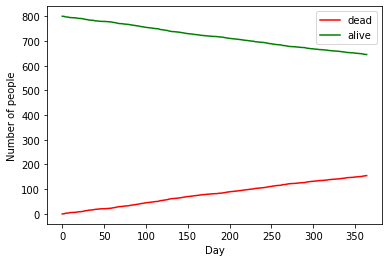

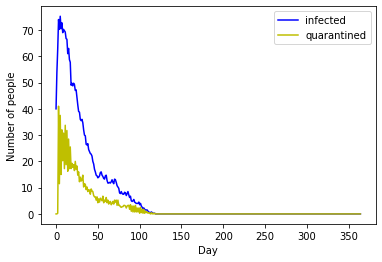

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 2.000000


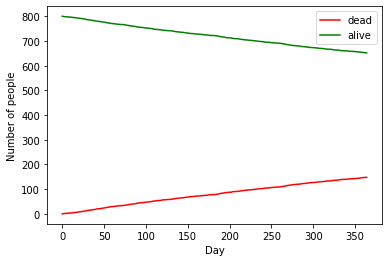

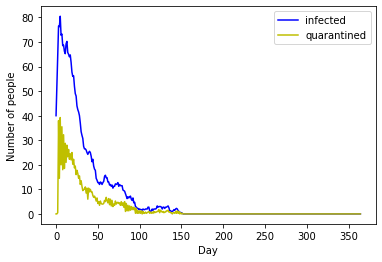

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 2.000000


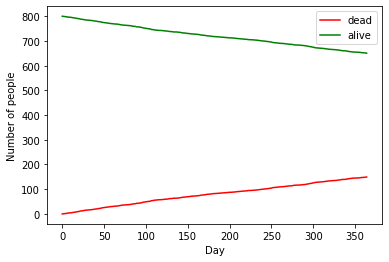

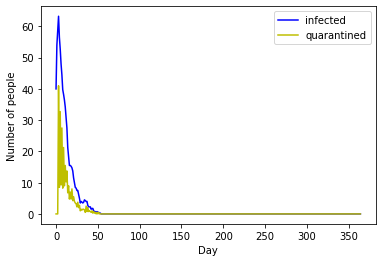

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 2.000000


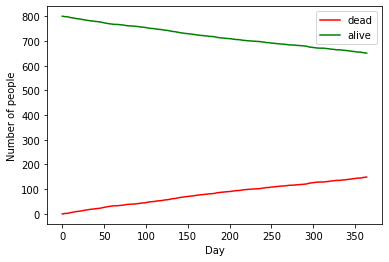

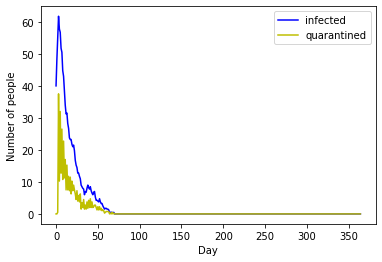

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 2.000000


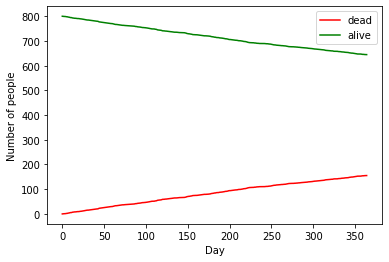

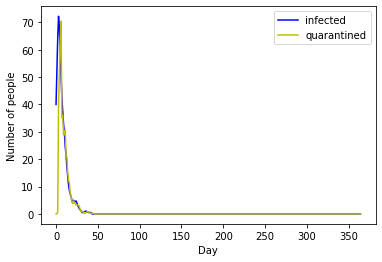

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 2.000000


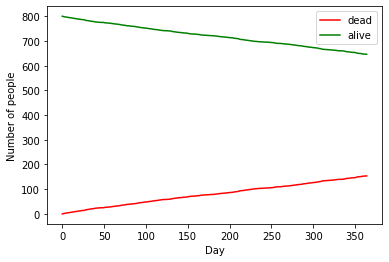

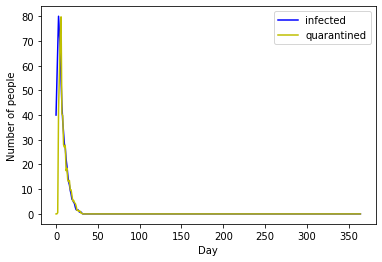

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 2.000000


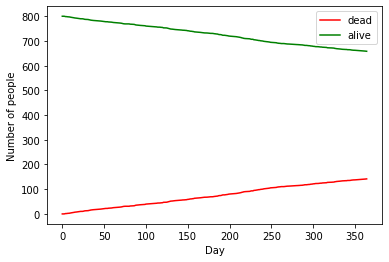

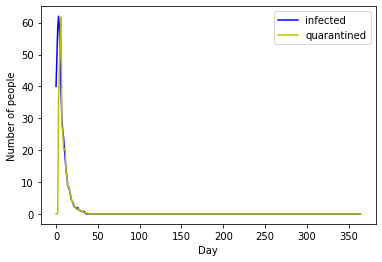

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 2.000000


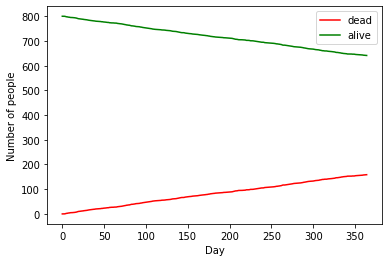

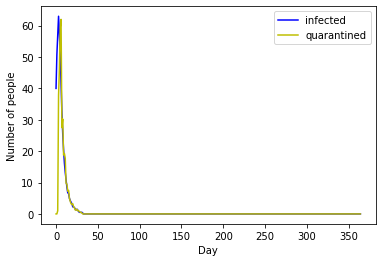

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 2.000000


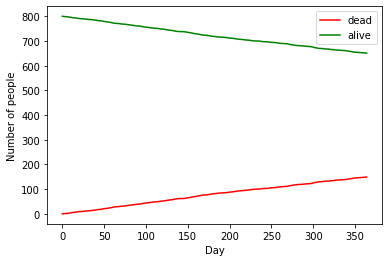

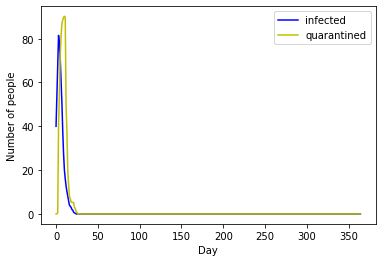

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 2.000000


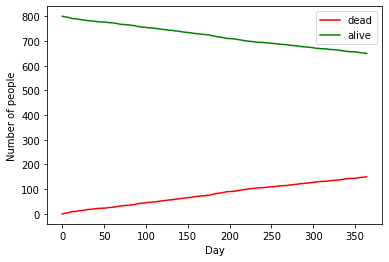

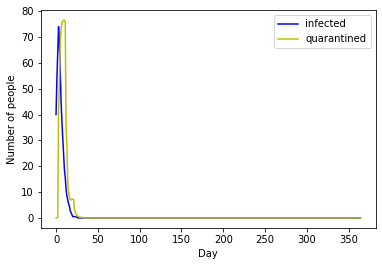

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 2.000000


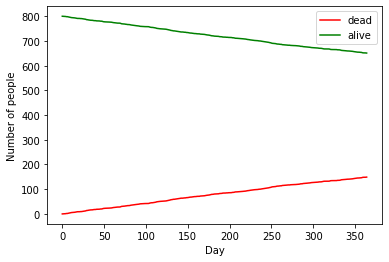

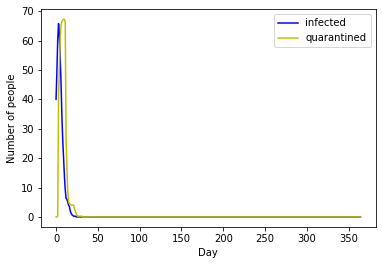

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 2.000000


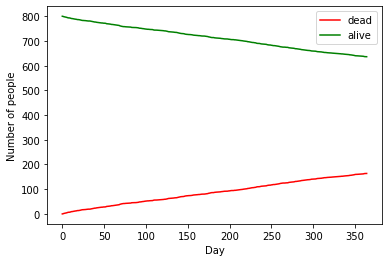

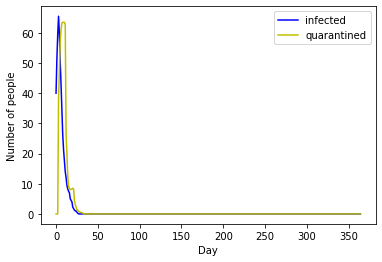

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 4.000000


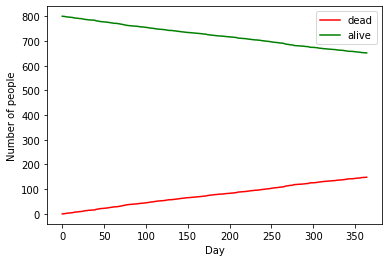

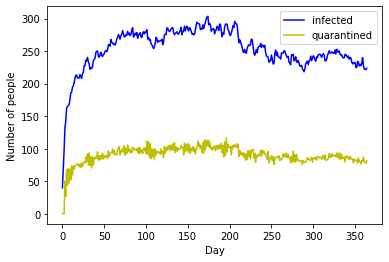

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 4.000000


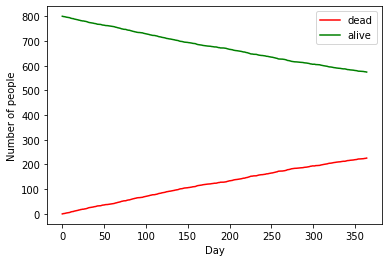

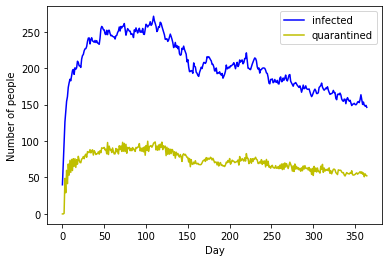

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 4.000000


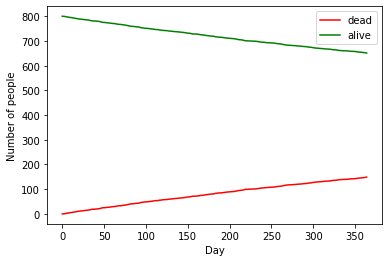

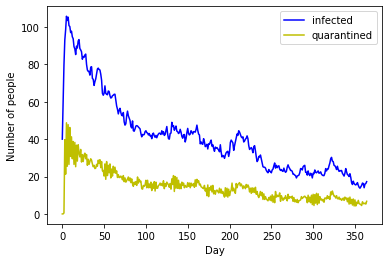

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 2.000000, Infectivity Parameter: 4.000000


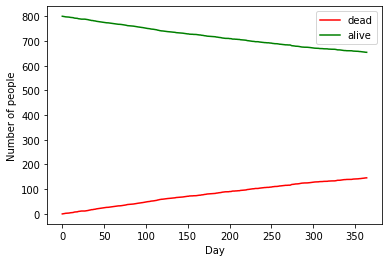

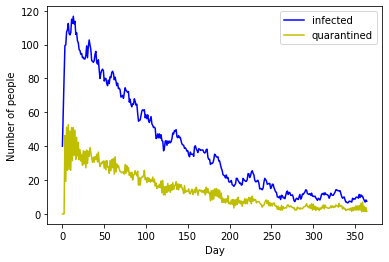

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 4.000000


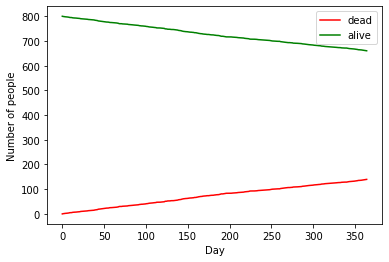

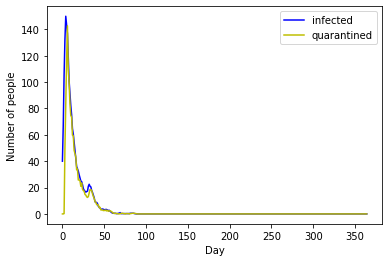

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 4.000000


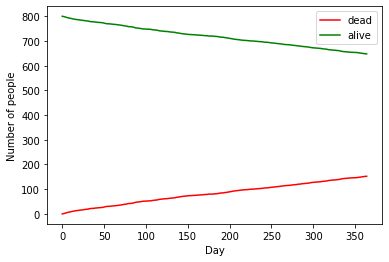

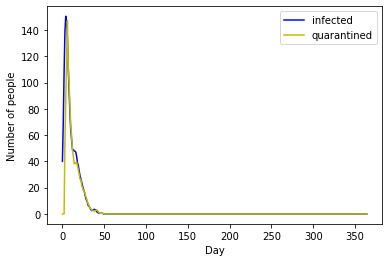

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 4.000000


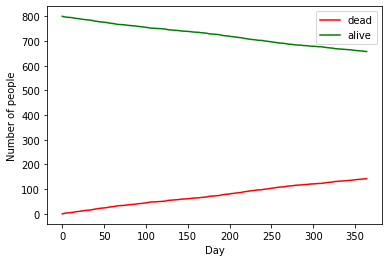

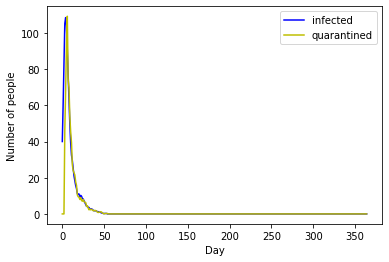

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 5.000000, Infectivity Parameter: 4.000000


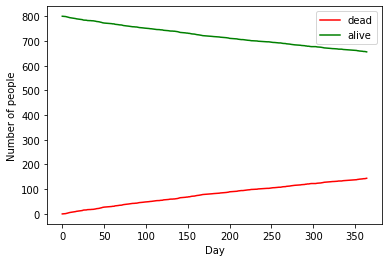

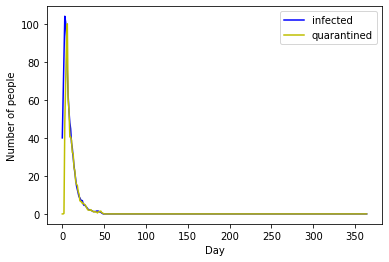

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 1.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 4.000000


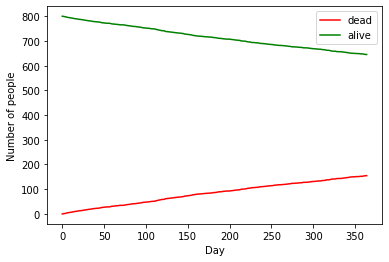

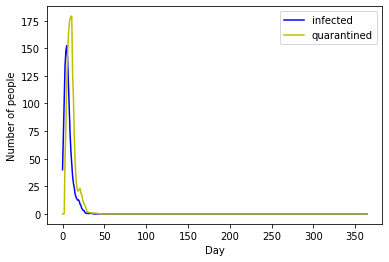

**Sim Parameters**: Vaccine Efficacy: 0.400000, Mortality Factor: 3.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 4.000000


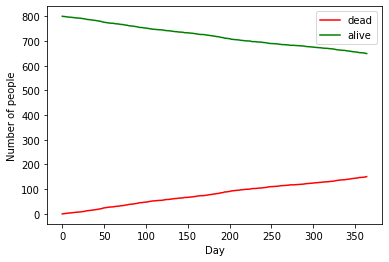

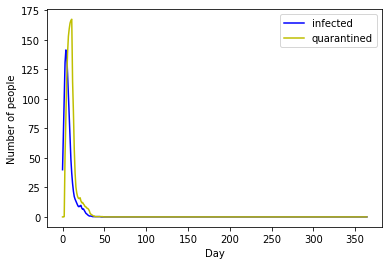

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 1.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 4.000000


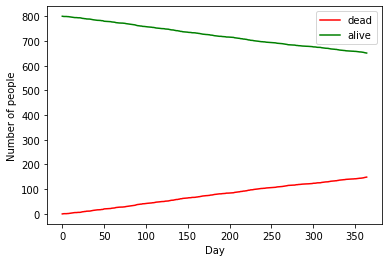

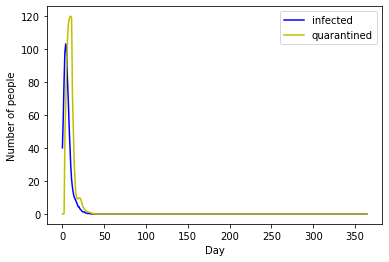

**Sim Parameters**: Vaccine Efficacy: 0.800000, Mortality Factor: 3.000000, Length of Quarantine: 10.000000, Infectivity Parameter: 4.000000


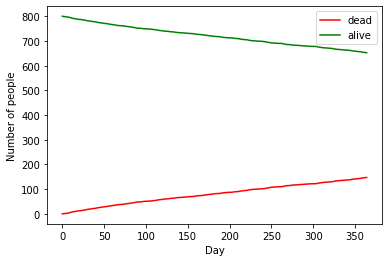

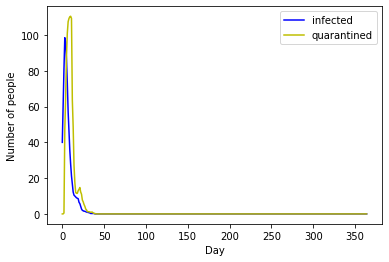

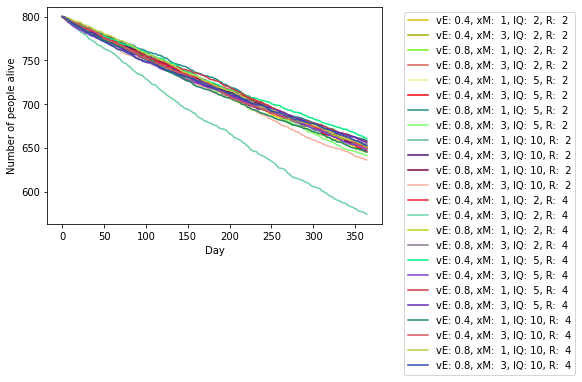

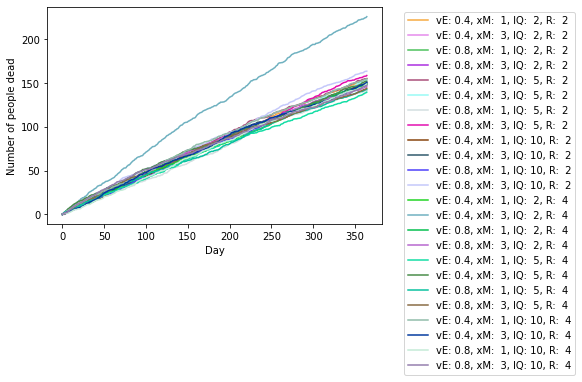

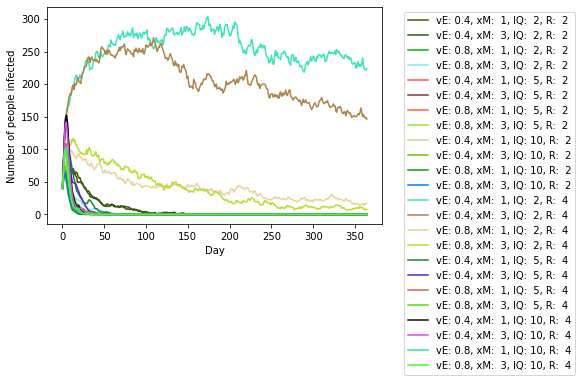

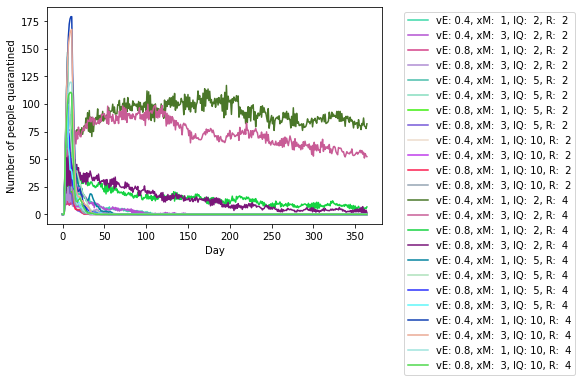

{'vaccination': False, 'testing': False, 'banFlights': False, 'lockdown': False}
    vE    xM    lQ    R     Alive    Dead    Infected    Quarantined
  0.4     1     2     2       645     155           0              0
  0.4     3     2     2       652     148           0              0
  0.8     1     2     2       650     150           0              0
  0.8     3     2     2       651     149           0              0
  0.4     1     5     2       645     155           0              0
  0.4     3     5     2       646     154           0              0
  0.8     1     5     2       658     142           0              0
  0.8     3     5     2       641     159           0              0
  0.4     1    10     2       651     149           0              0
  0.4     3    10     2       650     150           0              0
  0.8     1    10     2       651     149           0              0
  0.8     3    10     2       636     164           0              0
  0.4     1     2     

In [5]:
"""
Main Code
"""
from datetime import datetime

def setPolicies():
    #Code for final policy choice, vaccination
    def checkVaccinationChoice(testing, banFlights, lockdown):
        vaccinationChoice = input(str("Would you like vaccination to be true?\n"))
        if vaccinationChoice == "yes":
            return {"vaccination": True, "testing": testing, "banFlights": banFlights, "lockdown": lockdown}
        elif vaccinationChoice == "no":
            return {"vaccination": False, "testing": testing, "banFlights": banFlights, "lockdown": lockdown}


    #Code selecting which policies would be present in the world
    lockdownChoice = input(str("Would you like lockdown to be activated in the simulation?\n"))
    if lockdownChoice == "yes":
        return checkVaccinationChoice(True, True, True)

    elif lockdownChoice == "no":
        banFlightsChoice = input(str("Would you like to ban flights?\n"))
        if banFlightsChoice == "yes":
            return checkVaccinationChoice(True, True, False)
        elif banFlightsChoice == "no":
            testingChoice = input(str("Would you like testing?\n"))
            if testingChoice == "yes":
                return checkVaccinationChoice(True, False, False)
            elif testingChoice == "no":
                return checkVaccinationChoice(False, False, False)

activePolicies = None
while activePolicies == None:
    activePolicies = setPolicies()

#Params for different countries
NCountries = 4                  #Number of countries to set up per simulation
countryShape = (4, 4)           #Shape of the countries (i x j) matrix
population = 200                #Number of people in each country
vaccinated = 0.50               #Fraction of the population that is vaccinated at the start

#World parameters
vE = [0.40, 0.80]    #Vaccine Efficacy
xM = [1, 3]          #Mortality Factor
nQ = [2, 5, 10]      #Length of Quarantine
R  = [2, 4]          #Infectivity Parameter

NWorldsPerSimulation = 4          #Number of simulations to run per simulation 
NDaysPerSimulation = 365          #Number of days per simulation 

if __name__ == "__main__":

    #Find all the combinations of parameters
    parameterCombinations = np.array(np.meshgrid(vE, xM, nQ, R)).T.reshape(-1, 4)
    stats = np.empty(len(parameterCombinations), dtype=object)

    #For each combination of parameters, create and run a new simulation
    for i in range(len(parameterCombinations)):
        worldParameters = parameterCombinations[i]
        sim = Simulation(NWorldsPerSimulation, NDaysPerSimulation, worldParameters, NCountries, countryShape, population, vaccinated, activePolicies)
        sim.run()

        print("**Sim Parameters**: Vaccine Efficacy: {:5f}, Mortality Factor: {:3f}, Length of Quarantine: {:3f}, Infectivity Parameter: {:3f}".format(*worldParameters))
        stats[i] = sim.plot()

    #Plot all the data
    for i, stat in enumerate(["alive", "dead", "infected", "quarantined"]):
        for j in range(len(stats)):
            x = np.array(range(NDaysPerSimulation))
            plt.plot(x, stats[j][i], label = "vE: {:2.1f}, xM: {:2.0f}, lQ: {:2.0f}, R: {:2.0f}".format(*parameterCombinations[j]), color=np.random.rand(3, ))
        plt.xlabel("Day")
        plt.ylabel("Number of people {:s}".format(stat))
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.show()

    #Print the summary data and write to file
    with open("simulation_{:s}.txt".format(datetime.now()), "w+") as f:
        print(activePolicies)
        print("    vE    xM    lQ    R     Alive    Dead    Infected    Quarantined")
        f.write("vE,xM,lQ,R,Alive,Dead,Infected,Quarantined\n")
        for p in range(len(stats)):
            print("{:5.1f} {:5.0f} {:5.0f} {:5.0f}  {:8.0f}{:8.0f}{:12.0f}{:15.0f}".format(*parameterCombinations[p], stats[p][0][NDaysPerSimulation - 1],
                stats[p][1][NDaysPerSimulation - 1], stats[p][2][NDaysPerSimulation - 1], stats[p][3][NDaysPerSimulation - 1]))
            f.write("{:.1f},{:.0f},{:.0f},{:.0f},{:.0f},{:.0f},{:.0f},{:.0f}\n".format(*parameterCombinations[p], stats[p][0][NDaysPerSimulation - 1],
                stats[p][1][NDaysPerSimulation - 1], stats[p][2][NDaysPerSimulation - 1], stats[p][3][NDaysPerSimulation - 1]))


__Conclusion__

Death rates seems to be consistently within the range of 140 - 160 throughout almost every possible simulation scenario, given the simulation parameters and equations. The only major outlier would be if no policies are implemented with the worst case scenario.

With no policies, the worst case scenario (vE = 0.4, xM = 3, lQ = 2, R = 4) has a significantly higher death rate of ~220. Activating the vaccination policy or the testing policy causes that scenario to return to the normal death rate of ~140-160.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5888582a-c2b8-4759-9805-83cdd437182d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>